# Day 11: More on Neural Networks

### BUSI 520 - Python for Business Research
### Kerry Back, JGSB, Rice University

### Outline 

- Gradient descent
- Backpropagation
- Automatic differentiation
- Pytorch 

### Fitting a neural network

* Let $\theta$ denote all of the bias and weight parameters.  Consider observation $i$ with target value $y_i$ and features $x_i$.  Denote the
prediction of the network by $h(x_i, \theta)$.  
* In regression, we want to minimize 
$$ \frac{1}{2} \text{SSE} = \frac{1}{2}\sum_{i=1}^n [y_i - h(x_i, \theta)]^2.$$
* The gradient with respect to $\theta$ is 
$$ \sum_{i=1}^n [y_i - h(x_i, \theta)] \nabla_\theta h(x_i, \theta)$$
- To minimize, we want to take a step in the opposite direction of the gradient (gradient descent).

### Mini-batch gradient descent

* The overall gradient is a sum over all training samples:
$$ \sum_{i=1}^n [y_i - h(x_i, \theta)] \nabla_\theta h(x_i, \theta)$$
* Should we wait until we have added all of these together before taking a step?
* Instead, add up 100, take a small step, add up another 100, etc. (or different number than 100).
* After going through all observations, shuffle them and start again (called a new epoch).

### Stochastic gradient descent

- Batch size = 1 is called stochastic gradient descent.
- This means that the gradient is calculated and a step is taken for each observation.

### Example of gradient calculation

* Suppose there is only a single hidden layer with a single neuron. 
* Let $\theta = (\theta_1, \theta_2)$ where $\theta_1 = (b, w)$ of the
hidden layer neuron and $\theta_2 = (b, w)$ of the output layer.
* Let $y_i = f(x_i, \theta_1)$ denote the hidden layer neuron value.
* Let $z_i = g(y_i, \theta_2)$ denote the output layer value.
* The network prediction is 
$$h(x_i, \theta_1, \theta_2) = g(f(x_i, \theta_1), \theta_2)$$

### Chain Rule

* The gradient of $h$ in $\theta_2$ is
$$\nabla_{\theta_2} h(x_i, \theta) = \nabla_{\theta_2} g(y_i, \theta_2)$$
* The gradient of $h$ in $\theta_1$ is
$$\nabla_{\theta_1} h(x_i, \theta) = \frac{\partial g(y_i, \theta_2)}{\partial y_i}\nabla_{\theta_1} f(x_i, \theta_1)$$

### Forward and backward passes

* In a forward pass, the outputs of all the neurons are calculated, given the parameters.
* The gradients with respect to the parameters are calculated at the same time the functions are calculated.
* In the backward pass, the gradients are multiplied together as prescribed by the chain rule to get the overall derivative.
* Once the overall derivative is known, $\theta$ is adjusted by taking a step in the opposite direction of the gradient (gradient descent).

### Automatic differentiation

- A standard way to numerically calculate a derivative is to choose a small $\epsilon$ and calculate 
$$\frac{f(x + \epsilon) - f(x-\epsilon)}{2\epsilon}$$
- But there is a better way: automatic differentiation.
- Available in pytorch and tensorflow though not scikit-learn.

From Wikipedia: 

Automatic differentiation exploits the fact that every computer calculation, no matter how complicated, executes a sequence of elementary arithmetic operations (addition, subtraction, multiplication, division, etc.) and elementary functions (exp, log, sin, cos, etc.). By applying the chain rule repeatedly to these operations, partial derivatives of arbitrary order can be computed automatically, accurately to working precision, and using at most a small constant factor of more arithmetic operations than the original program.

### Automatic differentiation example

- Can use pytorch, tensorflow, jax, or autograd.

In [1]:
from autograd import grad

def fun(x):
    x1, x2 = x
    return x1**2 + x2**2

fun_grad = grad(fun)

fun_grad([1., 2.])


[array(2.), array(4.)]

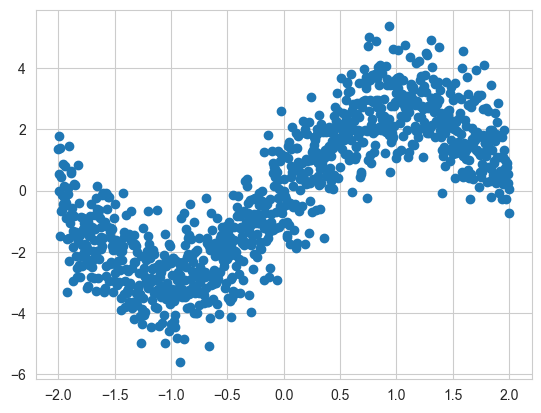

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")

# some artificial data

np.random.seed(0)
size = 1000

x = np.linspace(-2, 2, size)
y = 2.9 * np.sin(1.5 * x) + np.random.normal(size=size)

# view data
plt.scatter(x, y)
plt.show()

### Install pytorch 

- Use `pip install torch` or `pip3 install torch` 
- Restart your kernel!

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

### Train-test split

In [5]:
# create n x 1 arrays
X = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### Standard scaler

In [6]:
# only important when you have multiple features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Convert to pytorch tensors

In [7]:
X_train_scaled_tensor = torch.tensor(
    X_train_scaled, dtype=torch.float32
)
X_test_scaled_tensor = torch.tensor(
    X_test_scaled, dtype=torch.float32
)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### Build your network

In [8]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()

        # first hidden layer consists of 16 neurons
        self.fc1 = nn.Linear(1, 16)

        # second hidden layer consists of 8 neurons
        self.fc2 = nn.Linear(16, 8)

        # third hidden layer consists of 4 neurons
        self.fc3 = nn.Linear(8, 4)

        # output layer consists of 1 neuron
        self.fc4 = nn.Linear(4, 1)

    # forward pass through all four layers
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

model = MyNeuralNetwork()

### Define loss function and optimizer

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Fit the network

- This uses single batch gradient descent.
- For mini-batch gradient descent, use a loop over the batches within the loop over epochs.
- BatchLoader is a class that can be used to create batches.

In [11]:
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_scaled_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 4.0419
Epoch [200/1000], Loss: 1.8949
Epoch [300/1000], Loss: 1.6183
Epoch [400/1000], Loss: 1.3875
Epoch [500/1000], Loss: 1.1839
Epoch [600/1000], Loss: 1.0458
Epoch [700/1000], Loss: 1.0072
Epoch [800/1000], Loss: 0.9948
Epoch [900/1000], Loss: 0.9926
Epoch [1000/1000], Loss: 0.9921


### Evaluate performance

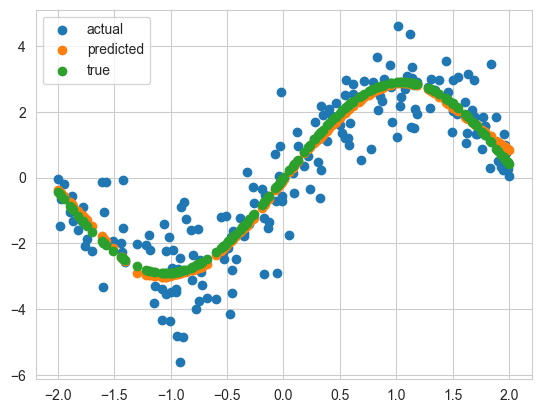

In [12]:
# predicted y's
y_hat = model(X_test_scaled_tensor).detach().numpy().flatten()

# true y's (without noise)
y_true = 2.9 * np.sin(1.5 * X_test)

plt.scatter(X_test, y_test, label="actual")
plt.scatter(X_test, y_hat, label="predicted")
plt.scatter(X_test, y_true, label="true")

plt.legend()
plt.show()